In [255]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import scipy.stats as sps


sns.set()

# SCRAPES THE LATEST DATA FROM WORLDOMETERS
url = 'https://www.worldometers.info/coronavirus/#countries'

r = requests.get(url)

c = r.content

soup = bs(c,'html.parser')
html = soup.find('html')
body = html.find('body')
div1 = body.find('div',{'class' : 'container'})
div2 = div1.findAll('div')

foo = soup.findAll('div',{'class' : 'tab-content'})
print (len(foo))

the_div = foo[2]

tbody = the_div.tbody

rows = tbody.findAll('tr')

countries = dict()

for r in rows:
    td = r.findAll('td')
    name = td[0].get_text().strip()
    confirmed = td[1].get_text().strip()
    inc = td[2].get_text().strip()
    deaths = td[3].get_text().strip()
    d_inc = td[4].get_text().strip()
    recovered = td[5].get_text().strip()
    active_cases = td[6].get_text().strip()
    serious = td[7].get_text().strip()
    conf_p_M = td[8].get_text().strip()
    countries[name] = [confirmed,inc,deaths,d_inc,
                       recovered,active_cases,serious,conf_p_M]
    
cols = ['confirmed','inc','dead','dead_inc','recovered',
        'active_cases','serious','confirmed_per_M']

df = pd.DataFrame.from_dict(countries)
df = df.T
df.columns = cols

df[['inc','dead_inc']] = df[['inc','dead_inc']].apply(
    lambda x : x.str.replace('+',''))

df[['confirmed','dead','recovered','active_cases',
    'serious','inc','dead_inc','confirmed_per_M']] = \
    df[['confirmed','dead','recovered','active_cases',
        'serious','inc','dead_inc','confirmed_per_M']].apply(
    lambda x : x.str.replace(',',''))

df[cols] = df[cols].apply(lambda x: x.replace('',np.nan))


df[cols] = df[cols].astype(float)
df['yesterday'] = df['confirmed'] - df['inc']
df['factor'] = df['confirmed'] / df['yesterday']
cols  = ['confirmed', 'yesterday','inc', 'factor','dead', 'dead_inc', 'recovered', 'active_cases',
       'serious', 'confirmed_per_M']

df = df[cols]

#df['factor'].loc[df['factor'] == np.inf]
df['factor'] = df['factor'].replace(np.inf,np.nan)
df['dead_pct'] = 100 * df['dead'] / df['confirmed']
df['dead'] = df['dead'].fillna(0)

df.head(40)

3


,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct
China,80894.0,80881.0,13.0,1.000161,3237.0,11.0,69614.0,8043.0,2622.0,56.0,4.001533
Italy,35713.0,31506.0,4207.0,1.133530,2978.0,475.0,4025.0,28710.0,2257.0,591.0,8.338700
Iran,17361.0,16169.0,1192.0,1.073721,1135.0,147.0,5710.0,10516.0,NaN,207.0,6.537642
Spain,13910.0,11826.0,2084.0,1.176222,623.0,90.0,1081.0,12206.0,563.0,298.0,4.478792
Germany,11973.0,9367.0,2606.0,1.278211,28.0,2.0,86.0,11859.0,2.0,143.0,0.233860
S. Korea,8413.0,8320.0,93.0,1.011178,84.0,3.0,1540.0,6789.0,59.0,164.0,0.998455
France,7730.0,NaN,NaN,NaN,175.0,NaN,602.0,6953.0,699.0,118.0,2.263907
USA,7708.0,6411.0,1297.0,1.202309,120.0,11.0,106.0,7482.0,12.0,23.0,1.556824
Switzerland,3076.0,2742.0,334.0,1.121809,33.0,6.0,15.0,3028.0,NaN,355.0,1.072822
UK,2626.0,1950.0,676.0,1.346667,104.0,33.0,65.0,2457.0,20.0,39.0,3.960396


In [256]:
df.sum()


confirmed          213727.000000
yesterday          187298.000000
inc                 15509.000000
factor                140.892212
dead                 8794.000000
dead_inc              827.000000
recovered           84314.000000
active_cases       120619.000000
serious              6636.000000
confirmed_per_M     14539.130000
dead_pct              352.389858
dtype: float64

In [257]:
today = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')
file_prefix = 'snapshots/corona_snapshot_'
filename = file_prefix + today.replace(' ','_').replace(':','_') + '.pkl'
df['datetime'] = [today] * len(df)
df.set_index([df.index,'datetime'],drop=True).to_pickle(filename)
df.head()

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,datetime
China,80894.0,80881.0,13.0,1.000161,3237.0,11.0,69614.0,8043.0,2622.0,56.0,4.001533,2020-03-18 19:25:33
Italy,35713.0,31506.0,4207.0,1.133530,2978.0,475.0,4025.0,28710.0,2257.0,591.0,8.338700,2020-03-18 19:25:33
Iran,17361.0,16169.0,1192.0,1.073721,1135.0,147.0,5710.0,10516.0,NaN,207.0,6.537642,2020-03-18 19:25:33
Spain,13910.0,11826.0,2084.0,1.176222,623.0,90.0,1081.0,12206.0,563.0,298.0,4.478792,2020-03-18 19:25:33
Germany,11973.0,9367.0,2606.0,1.278211,28.0,2.0,86.0,11859.0,2.0,143.0,0.233860,2020-03-18 19:25:33


In [258]:
import glob
files = [f for f in glob.glob('./' + file_prefix +'*')]

timeline_df = pd.DataFrame()

for f in files:
    temp = pd.read_pickle(f)
    timeline_df = pd.concat([timeline_df,temp],axis=0)
    
timeline_df.sort_index(inplace=True)
timeline_df['dead'] = timeline_df['dead'].fillna(0)
timeline_df

confirmed  yesterday  inc    factor  dead  \
            datetime                                                         
Afghanistan 2020-03-15 15:50:08       16.0       11.0  5.0  1.454545   0.0   
            2020-03-15 16:55:44       16.0       11.0  5.0  1.454545   0.0   
            2020-03-15 19:43:02       16.0       11.0  5.0  1.454545   0.0   
            2020-03-15 21:46:07       16.0       11.0  5.0  1.454545   0.0   
            2020-03-15 22:21:09       16.0       11.0  5.0  1.454545   0.0   
...                                    ...        ...  ...       ...   ...   
Zambia      2020-03-18 16:55:09        2.0        0.0  2.0       NaN   0.0   
            2020-03-18 18:51:01        2.0        0.0  2.0       NaN   0.0   
            2020-03-18 18:56:13        2.0        0.0  2.0       NaN   0.0   
            2020-03-18 19:10:11        2.0        0.0  2.0       NaN   0.0   
            2020-03-18 19:25:33        2.0        0.0  2.0       NaN   0.0   

                                 dead_inc  recovered  active_cases  serious  \
            datetime                                                          
Afghanistan 2020-03-15 15:50:08       NaN        1.0          15.0      NaN   
            2020-03-15 16:55:44       NaN        1.0          15.0      NaN   
            2020-03-15 19:43:02       NaN        1.0          15.0      NaN   
            2020-03-15 21:46:07       NaN        1.0          15.0      NaN   
            2020-03-15 22:21:09       NaN        1.0          15.0      NaN   
...                                   ...        ...           ...      ...   
Zambia      2020-03-18 16:55:09       NaN        NaN           2.0      NaN   
            2020-03-18 18:51:01       NaN        NaN           2.0      NaN   
            2020-03-18 18:56:13       NaN        NaN           2.0      NaN   
            2020-03-18 19:10:11       NaN        NaN           2.0      NaN   
            2020-03-18 19:25:33       NaN        NaN           2.0      NaN   

                                 confirmed_per_M  dead_pct  
            datetime                                        
Afghanistan 2020-03-15 15:50:08              0.4       NaN  
            2020-03-15 16:55:44              0.4       NaN  
            2020-03-15 19:43:02              0.4       NaN  
            2020-03-15 21:46:07              0.4       NaN  
            2020-03-15 22:21:09              0.4       NaN  
...                                          ...       ...  
Zambia      2020-03-18 16:55:09              0.1       NaN  
            2020-03-18 18:51:01              0.1       NaN  
            2020-03-18 18:56:13              0.1       NaN  
            2020-03-18 19:10:11              0.1       NaN  
            2020-03-18 19:25:33              0.1       NaN  

[8831 rows x 11 columns]

In [259]:
timeline_group = timeline_df.groupby(level=0)

a_country = timeline_group.get_group('USA')
a_country

confirmed  yesterday     inc    factor   dead  \
    datetime                                                             
USA 2020-03-15 15:50:08     3083.0     2943.0   140.0  1.047571   60.0   
    2020-03-15 16:55:44     3094.0     2943.0   151.0  1.051308   62.0   
    2020-03-15 19:43:02     3326.0     2943.0   383.0  1.130139   63.0   
    2020-03-15 21:46:07     3457.0     2943.0   514.0  1.174652   63.0   
    2020-03-15 22:21:09     3621.0     2943.0   678.0  1.230377   63.0   
    2020-03-15 22:23:46     3621.0     2943.0   678.0  1.230377   63.0   
    2020-03-15 22:34:01     3621.0     2943.0   678.0  1.230377   63.0   
    2020-03-15 23:37:02     3557.0     2943.0   614.0  1.208631   68.0   
    2020-03-15 23:38:04     3557.0     2943.0   614.0  1.208631   68.0   
    2020-03-16 08:41:58     3782.0     3680.0   102.0  1.027717   69.0   
    2020-03-16 10:29:44     3802.0     3680.0   122.0  1.033152   69.0   
    2020-03-16 10:42:31     3802.0     3680.0   122.0  1.033152   69.0   
    2020-03-16 10:59:30     3802.0     3680.0   122.0  1.033152   69.0   
    2020-03-16 12:09:38     3802.0     3680.0   122.0  1.033152   69.0   
    2020-03-16 13:03:36     3802.0     3680.0   122.0  1.033152   69.0   
    2020-03-16 14:09:44     3806.0     3680.0   126.0  1.034239   69.0   
    2020-03-16 14:22:25     3807.0     3680.0   127.0  1.034511   69.0   
    2020-03-16 16:04:29     3814.0     3680.0   134.0  1.036413   70.0   
    2020-03-16 16:35:41     3837.0     3680.0   157.0  1.042663   70.0   
    2020-03-16 16:54:13     4040.0     3680.0   360.0  1.097826   70.0   
    2020-03-16 18:13:22     4108.0     3680.0   428.0  1.116304   71.0   
    2020-03-16 19:48:19     4186.0     3680.0   506.0  1.137500   73.0   
    2020-03-16 20:35:05     4252.0     3680.0   572.0  1.155435   75.0   
    2020-03-16 21:44:20     4334.0     3680.0   654.0  1.177717   77.0   
    2020-03-16 22:22:56     4430.0     3680.0   750.0  1.203804   77.0   
    2020-03-17 09:27:40     4736.0     4663.0    73.0  1.015655   93.0   
    2020-03-17 10:40:22     4743.0     4663.0    80.0  1.017156   93.0   
    2020-03-17 13:58:53     4744.0     4663.0    81.0  1.017371   93.0   
    2020-03-17 15:16:49     4748.0     4663.0    85.0  1.018229   93.0   
    2020-03-17 16:41:28     5243.0     4663.0   580.0  1.124383   94.0   
    2020-03-17 17:36:32     5672.0     4663.0  1009.0  1.216384   96.0   
    2020-03-17 17:46:33     5686.0     4663.0  1023.0  1.219387   97.0   
    2020-03-17 18:08:54     5696.0     4663.0  1033.0  1.221531   97.0   
    2020-03-17 18:23:21     5696.0     4663.0  1033.0  1.221531   97.0   
    2020-03-17 19:52:34     5723.0     4663.0  1060.0  1.227321   97.0   
    2020-03-17 19:59:11     5839.0     4663.0  1176.0  1.252198   99.0   
    2020-03-17 20:02:26     5863.0     4663.0  1200.0  1.257345   99.0   
    2020-03-17 20:05:15     5863.0     4663.0  1200.0  1.257345   99.0   
    2020-03-17 21:11:09     5917.0     4663.0  1254.0  1.268926   99.0   
    2020-03-17 21:30:03     5921.0     4663.0  1258.0  1.269783  100.0   
    2020-03-17 22:36:48     6176.0     4663.0  1513.0  1.324469  102.0   
    2020-03-17 23:06:02     6223.0     4663.0  1560.0  1.334549  103.0   
    2020-03-18 08:14:14     6524.0     6411.0   113.0  1.017626  116.0   
    2020-03-18 08:18:20     6524.0     6411.0   113.0  1.017626  116.0   
    2020-03-18 13:10:25     6524.0     6411.0   113.0  1.017626  116.0   
    2020-03-18 14:08:55     6534.0     6411.0   123.0  1.019186  116.0   
    2020-03-18 14:10:54     6534.0     6411.0   123.0  1.019186  116.0   
    2020-03-18 14:12:28     6534.0     6411.0   123.0  1.019186  116.0   
    2020-03-18 16:05:48     7387.0     6411.0   976.0  1.152238  116.0   
    2020-03-18 16:55:09     7411.0     6411.0  1000.0  1.155982  116.0   
    2020-03-18 18:51:01     7687.0     6411.0  1276.0  1.199033  117.0   
    2020-03-18 18:56:13     7687.0     6411.0  1276.0  1.199033  117.0   
    2020-03-18 19:10:11     7

In [260]:
non_duplicates = ( ( a_country['confirmed'] != a_country['confirmed'].shift() )  | (
    a_country['dead'] != a_country['dead'].shift()))

a_country = a_country[non_duplicates]
a_country

confirmed  yesterday     inc    factor   dead  \
    datetime                                                             
USA 2020-03-15 15:50:08     3083.0     2943.0   140.0  1.047571   60.0   
    2020-03-15 16:55:44     3094.0     2943.0   151.0  1.051308   62.0   
    2020-03-15 19:43:02     3326.0     2943.0   383.0  1.130139   63.0   
    2020-03-15 21:46:07     3457.0     2943.0   514.0  1.174652   63.0   
    2020-03-15 22:21:09     3621.0     2943.0   678.0  1.230377   63.0   
    2020-03-15 23:37:02     3557.0     2943.0   614.0  1.208631   68.0   
    2020-03-16 08:41:58     3782.0     3680.0   102.0  1.027717   69.0   
    2020-03-16 10:29:44     3802.0     3680.0   122.0  1.033152   69.0   
    2020-03-16 14:09:44     3806.0     3680.0   126.0  1.034239   69.0   
    2020-03-16 14:22:25     3807.0     3680.0   127.0  1.034511   69.0   
    2020-03-16 16:04:29     3814.0     3680.0   134.0  1.036413   70.0   
    2020-03-16 16:35:41     3837.0     3680.0   157.0  1.042663   70.0   
    2020-03-16 16:54:13     4040.0     3680.0   360.0  1.097826   70.0   
    2020-03-16 18:13:22     4108.0     3680.0   428.0  1.116304   71.0   
    2020-03-16 19:48:19     4186.0     3680.0   506.0  1.137500   73.0   
    2020-03-16 20:35:05     4252.0     3680.0   572.0  1.155435   75.0   
    2020-03-16 21:44:20     4334.0     3680.0   654.0  1.177717   77.0   
    2020-03-16 22:22:56     4430.0     3680.0   750.0  1.203804   77.0   
    2020-03-17 09:27:40     4736.0     4663.0    73.0  1.015655   93.0   
    2020-03-17 10:40:22     4743.0     4663.0    80.0  1.017156   93.0   
    2020-03-17 13:58:53     4744.0     4663.0    81.0  1.017371   93.0   
    2020-03-17 15:16:49     4748.0     4663.0    85.0  1.018229   93.0   
    2020-03-17 16:41:28     5243.0     4663.0   580.0  1.124383   94.0   
    2020-03-17 17:36:32     5672.0     4663.0  1009.0  1.216384   96.0   
    2020-03-17 17:46:33     5686.0     4663.0  1023.0  1.219387   97.0   
    2020-03-17 18:08:54     5696.0     4663.0  1033.0  1.221531   97.0   
    2020-03-17 19:52:34     5723.0     4663.0  1060.0  1.227321   97.0   
    2020-03-17 19:59:11     5839.0     4663.0  1176.0  1.252198   99.0   
    2020-03-17 20:02:26     5863.0     4663.0  1200.0  1.257345   99.0   
    2020-03-17 21:11:09     5917.0     4663.0  1254.0  1.268926   99.0   
    2020-03-17 21:30:03     5921.0     4663.0  1258.0  1.269783  100.0   
    2020-03-17 22:36:48     6176.0     4663.0  1513.0  1.324469  102.0   
    2020-03-17 23:06:02     6223.0     4663.0  1560.0  1.334549  103.0   
    2020-03-18 08:14:14     6524.0     6411.0   113.0  1.017626  116.0   
    2020-03-18 14:08:55     6534.0     6411.0   123.0  1.019186  116.0   
    2020-03-18 16:05:48     7387.0     6411.0   976.0  1.152238  116.0   
    2020-03-18 16:55:09     7411.0     6411.0  1000.0  1.155982  116.0   
    2020-03-18 18:51:01     7687.0     6411.0  1276.0  1.199033  117.0   
    2020-03-18 19:25:33     7708.0     6411.0  1297.0  1.202309  120.0   

                         dead_inc  recovered  active_cases  serious  \
    datetime                                                          
USA 2020-03-15 15:50:08       3.0       56.0        2967.0     10.0   
    2020-03-15 16:55:44       5.0       56.0        2976.0     10.0   
    2020-03-15 19:43:02       6.0       59.0        3204.0     10.0   
    2020-03-15 21:46:07       6.0       59.0        3335.0     10.0   
    2020-03-15 22:21:09       6.0       59.0        3499.0     10.0   
    2020-03-15 23:37:02      11.0       59.0        3430.0     10.0   
    2020-03-16 08:41:58       1.0       73.0        3640.0     10.0   
    2020-03-16 10:29:44       1.0       73.0        3660.0     10.0   
    2020-03-16 14:09:44       1.0       73.0        3664.0     10.0   
    2020-03-16 14:22:25       1.0       73.0        3665.0     12.0   
    2020-03-16 16:04:29       2.0       73.0        3671.0     12.0   
    2020-03-16 16:35:41       2.0       73.0        3694.0     12.0

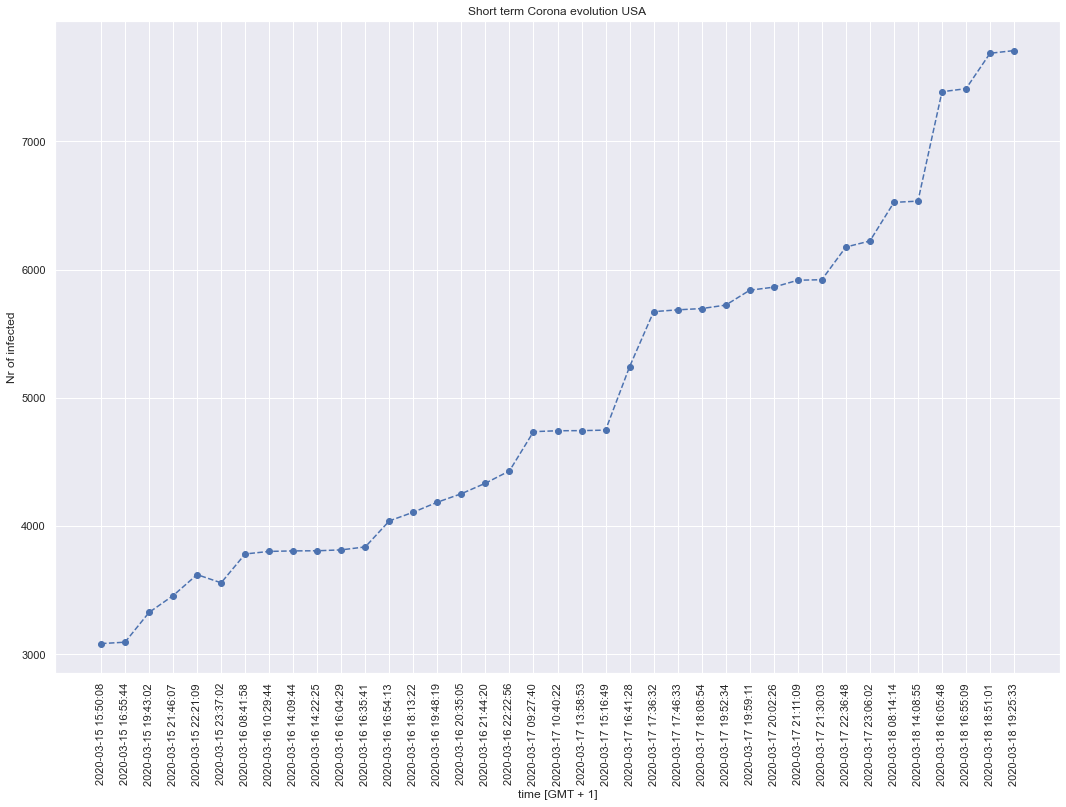

In [261]:


plt.figure(figsize=(18,12))
plt.title('Short term Corona evolution {}'.format(a_country.index[0][0]))
a_country['confirmed'].plot(style ='o--')
plt.xticks(rotation=90)
plt.xticks(range(len(a_country.index)),[a_country.index[i][1] for i in range(len(a_country.index))])
plt.xlabel('time [GMT + 1]')

plt.ylabel('Nr of infected')
#plt.ylabel(r'Nr of infected [ $10^{x}$ ]')
#plt.yscale('log')

filename = 'corona_short_term_' + a_country.index[0][0] + '.jpg'
plt.savefig (filename,format='jpg')


In [262]:
top_dead_pct = df.loc[df['confirmed'] > 500].sort_values('dead_pct',ascending=False)
top_dead_pct

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,datetime
Italy,35713.0,31506.0,4207.0,1.133530,2978.0,475.0,4025.0,28710.0,2257.0,591.0,8.338700,2020-03-18 19:25:33
Iran,17361.0,16169.0,1192.0,1.073721,1135.0,147.0,5710.0,10516.0,NaN,207.0,6.537642,2020-03-18 19:25:33
Spain,13910.0,11826.0,2084.0,1.176222,623.0,90.0,1081.0,12206.0,563.0,298.0,4.478792,2020-03-18 19:25:33
China,80894.0,80881.0,13.0,1.000161,3237.0,11.0,69614.0,8043.0,2622.0,56.0,4.001533,2020-03-18 19:25:33
UK,2626.0,1950.0,676.0,1.346667,104.0,33.0,65.0,2457.0,20.0,39.0,3.960396,2020-03-18 19:25:33
Japan,899.0,878.0,21.0,1.023918,29.0,NaN,144.0,726.0,41.0,7.0,3.225806,2020-03-18 19:25:33
Netherlands,2051.0,1705.0,346.0,1.202933,58.0,15.0,2.0,1991.0,45.0,120.0,2.827889,2020-03-18 19:25:33
France,7730.0,NaN,NaN,NaN,175.0,NaN,602.0,6953.0,699.0,118.0,2.263907,2020-03-18 19:25:33
USA,7708.0,6411.0,1297.0,1.202309,120.0,11.0,106.0,7482.0,12.0,23.0,1.556824,2020-03-18 19:25:33
Canada,598.0,NaN,NaN,NaN,8.0,NaN,12.0,578.0,1.0,16.0,1.337793,2020-03-18 19:25:33


In [263]:
country_names = sorted(df.index.values)
#country_names

In [264]:
df.loc[df['confirmed'] > 500 ].sort_values('factor',ascending=False)

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,datetime
Portugal,642.0,448.0,194.0,1.433036,2.0,1.0,4.0,636.0,18.0,63.0,0.311526,2020-03-18 19:25:33
UK,2626.0,1950.0,676.0,1.346667,104.0,33.0,65.0,2457.0,20.0,39.0,3.960396,2020-03-18 19:25:33
Germany,11973.0,9367.0,2606.0,1.278211,28.0,2.0,86.0,11859.0,2.0,143.0,0.233860,2020-03-18 19:25:33
Australia,565.0,455.0,110.0,1.241758,6.0,1.0,43.0,516.0,1.0,22.0,1.061947,2020-03-18 19:25:33
Austria,1646.0,1332.0,314.0,1.235736,4.0,NaN,9.0,1633.0,12.0,183.0,0.243013,2020-03-18 19:25:33
Netherlands,2051.0,1705.0,346.0,1.202933,58.0,15.0,2.0,1991.0,45.0,120.0,2.827889,2020-03-18 19:25:33
Czechia,522.0,434.0,88.0,1.202765,0.0,NaN,3.0,519.0,5.0,49.0,NaN,2020-03-18 19:25:33
USA,7708.0,6411.0,1297.0,1.202309,120.0,11.0,106.0,7482.0,12.0,23.0,1.556824,2020-03-18 19:25:33
Belgium,1486.0,1243.0,243.0,1.195495,14.0,4.0,31.0,1441.0,33.0,128.0,0.942127,2020-03-18 19:25:33
Spain,13910.0,11826.0,2084.0,1.176222,623.0,90.0,1081.0,12206.0,563.0,298.0,4.478792,2020-03-18 19:25:33


In [265]:
top_10_per_m = df.sort_values('confirmed_per_M',ascending=False).head(10)
top_10_per_m

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,datetime
San Marino,119.0,NaN,NaN,NaN,11.0,NaN,4.0,104.0,11.0,3507.0,9.243697,2020-03-18 19:25:33
Vatican City,1.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0,NaN,1248.0,NaN,2020-03-18 19:25:33
Faeroe Islands,58.0,47.0,11.0,1.234043,0.0,NaN,1.0,57.0,NaN,1187.0,NaN,2020-03-18 19:25:33
Iceland,250.0,247.0,3.0,1.012146,0.0,NaN,5.0,245.0,1.0,733.0,NaN,2020-03-18 19:25:33
Italy,35713.0,31506.0,4207.0,1.133530,2978.0,475.0,4025.0,28710.0,2257.0,591.0,8.338700,2020-03-18 19:25:33
Andorra,39.0,NaN,NaN,NaN,0.0,NaN,1.0,38.0,NaN,505.0,NaN,2020-03-18 19:25:33
Liechtenstein,19.0,NaN,NaN,NaN,0.0,NaN,NaN,19.0,NaN,498.0,NaN,2020-03-18 19:25:33
Switzerland,3076.0,2742.0,334.0,1.121809,33.0,6.0,15.0,3028.0,NaN,355.0,1.072822,2020-03-18 19:25:33
Luxembourg,203.0,140.0,63.0,1.450000,2.0,1.0,NaN,201.0,1.0,324.0,0.985222,2020-03-18 19:25:33
St. Barth,3.0,NaN,NaN,NaN,0.0,NaN,NaN,3.0,NaN,304.0,NaN,2020-03-18 19:25:33


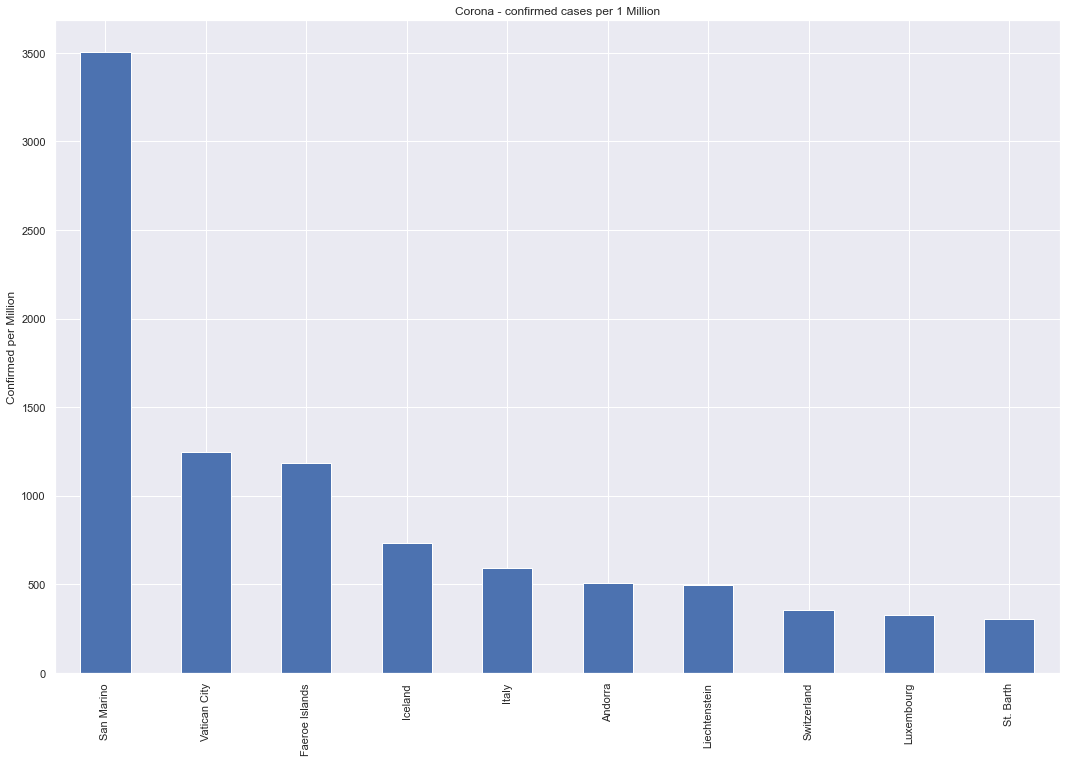

In [266]:
plt.figure(figsize=(18,12))
plt.title('Corona - confirmed cases per 1 Million')
plt.ylabel ('Confirmed per Million')
top_10_per_m['confirmed_per_M'].plot(kind='bar')
plt.savefig('confirmed_per_million.jpg',format='jpg')

In [267]:
totals = pd.DataFrame(df.sum(),columns=['totals'])
totals.drop(['factor','confirmed_per_M','dead_pct','datetime'],inplace=True)
totals

,totals
confirmed,213727
yesterday,187298
inc,15509
dead,8794
dead_inc,827
recovered,84314
active_cases,120619
serious,6636


In [268]:
country_names = list(sorted((df.index.unique().values)))
country_names

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'CAR',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cayman Islands',
 'Channel Islands',
 'Chile',
 'China',
 'Colombia',
 'Congo',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czechia',
 'DRC',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'Equatorial Guinea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Faeroe Islands',
 'Finland',
 'France',
 'French Guiana',
 'French Polynesia',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Gibraltar',
 'Greece',
 'Greenland',
 'Guadeloupe',
 'Guam',
 'Guatemala',
 'Guinea',
 'Guyana',
 'Honduras',
 'Hong Kong',
 'Hungary',
 'Iceland',
 'India',
 'Indo

In [269]:
some_countries = ['Sweden','USA','Italy','Spain','Norway','Finland',
                  'Denmark','Singapore','S. Korea','China','Russia',
                 'Poland','Taiwan','Estonia','Germany','Austria','Belgium','France','Canada']
countries_of_interest = df.loc[some_countries,:]
countries_of_interest.sort_values('confirmed',inplace=True,ascending=False)
countries_of_interest

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,datetime
China,80894.0,80881.0,13.0,1.000161,3237.0,11.0,69614.0,8043.0,2622.0,56.0,4.001533,2020-03-18 19:25:33
Italy,35713.0,31506.0,4207.0,1.133530,2978.0,475.0,4025.0,28710.0,2257.0,591.0,8.338700,2020-03-18 19:25:33
Spain,13910.0,11826.0,2084.0,1.176222,623.0,90.0,1081.0,12206.0,563.0,298.0,4.478792,2020-03-18 19:25:33
Germany,11973.0,9367.0,2606.0,1.278211,28.0,2.0,86.0,11859.0,2.0,143.0,0.233860,2020-03-18 19:25:33
S. Korea,8413.0,8320.0,93.0,1.011178,84.0,3.0,1540.0,6789.0,59.0,164.0,0.998455,2020-03-18 19:25:33
France,7730.0,NaN,NaN,NaN,175.0,NaN,602.0,6953.0,699.0,118.0,2.263907,2020-03-18 19:25:33
USA,7708.0,6411.0,1297.0,1.202309,120.0,11.0,106.0,7482.0,12.0,23.0,1.556824,2020-03-18 19:25:33
Austria,1646.0,1332.0,314.0,1.235736,4.0,NaN,9.0,1633.0,12.0,183.0,0.243013,2020-03-18 19:25:33
Norway,1562.0,1471.0,91.0,1.061863,6.0,3.0,1.0,1555.0,27.0,288.0,0.384123,2020-03-18 19:25:33
Belgium,1486.0,1243.0,243.0,1.195495,14.0,4.0,31.0,1441.0,33.0,128.0,0.942127,2020-03-18 19:25:33


In [270]:
countries_of_interest.sort_values('confirmed_per_M',ascending=False)

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,datetime
Italy,35713.0,31506.0,4207.0,1.133530,2978.0,475.0,4025.0,28710.0,2257.0,591.0,8.338700,2020-03-18 19:25:33
Spain,13910.0,11826.0,2084.0,1.176222,623.0,90.0,1081.0,12206.0,563.0,298.0,4.478792,2020-03-18 19:25:33
Norway,1562.0,1471.0,91.0,1.061863,6.0,3.0,1.0,1555.0,27.0,288.0,0.384123,2020-03-18 19:25:33
Estonia,258.0,225.0,33.0,1.146667,0.0,NaN,1.0,257.0,1.0,194.0,NaN,2020-03-18 19:25:33
Austria,1646.0,1332.0,314.0,1.235736,4.0,NaN,9.0,1633.0,12.0,183.0,0.243013,2020-03-18 19:25:33
Denmark,1057.0,977.0,80.0,1.081883,4.0,NaN,1.0,1052.0,24.0,182.0,0.378430,2020-03-18 19:25:33
S. Korea,8413.0,8320.0,93.0,1.011178,84.0,3.0,1540.0,6789.0,59.0,164.0,0.998455,2020-03-18 19:25:33
Germany,11973.0,9367.0,2606.0,1.278211,28.0,2.0,86.0,11859.0,2.0,143.0,0.233860,2020-03-18 19:25:33
Belgium,1486.0,1243.0,243.0,1.195495,14.0,4.0,31.0,1441.0,33.0,128.0,0.942127,2020-03-18 19:25:33
Sweden,1292.0,1196.0,96.0,1.080268,10.0,2.0,1.0,1281.0,12.0,128.0,0.773994,2020-03-18 19:25:33


In [271]:
european_countries = pd.read_csv('european_countries.csv',sep=';',
                     encoding='ISO-8859-1',header=None,
                     names=['country','population','region'],
                    thousands=',')
europe_names = list(european_countries['country'].values)

try:
    europe = df.loc[europe_names,:]
except KeyError:
    print ('some country from european_countries missing from dataset')
    
europe.sort_values('confirmed',ascending=False,inplace=True)
europe

,confirmed,yesterday,inc,factor,dead,dead_inc,recovered,active_cases,serious,confirmed_per_M,dead_pct,datetime
Italy,35713.0,31506.0,4207.0,1.133530,2978.0,475.0,4025.0,28710.0,2257.0,591.0,8.338700,2020-03-18 19:25:33
Spain,13910.0,11826.0,2084.0,1.176222,623.0,90.0,1081.0,12206.0,563.0,298.0,4.478792,2020-03-18 19:25:33
Germany,11973.0,9367.0,2606.0,1.278211,28.0,2.0,86.0,11859.0,2.0,143.0,0.233860,2020-03-18 19:25:33
France,7730.0,NaN,NaN,NaN,175.0,NaN,602.0,6953.0,699.0,118.0,2.263907,2020-03-18 19:25:33
Switzerland,3076.0,2742.0,334.0,1.121809,33.0,6.0,15.0,3028.0,NaN,355.0,1.072822,2020-03-18 19:25:33
UK,2626.0,1950.0,676.0,1.346667,104.0,33.0,65.0,2457.0,20.0,39.0,3.960396,2020-03-18 19:25:33
Netherlands,2051.0,1705.0,346.0,1.202933,58.0,15.0,2.0,1991.0,45.0,120.0,2.827889,2020-03-18 19:25:33
Austria,1646.0,1332.0,314.0,1.235736,4.0,NaN,9.0,1633.0,12.0,183.0,0.243013,2020-03-18 19:25:33
Norway,1562.0,1471.0,91.0,1.061863,6.0,3.0,1.0,1555.0,27.0,288.0,0.384123,2020-03-18 19:25:33
Belgium,1486.0,1243.0,243.0,1.195495,14.0,4.0,31.0,1441.0,33.0,128.0,0.942127,2020-03-18 19:25:33


In [272]:
europe_sum = europe[['confirmed','yesterday','inc','dead','dead_inc','recovered','active_cases']].sum()
europe_sum

confirmed       89052.0
yesterday       69041.0
inc             11786.0
dead             4073.0
dead_inc          634.0
recovered        6015.0
active_cases    78964.0
dtype: float64

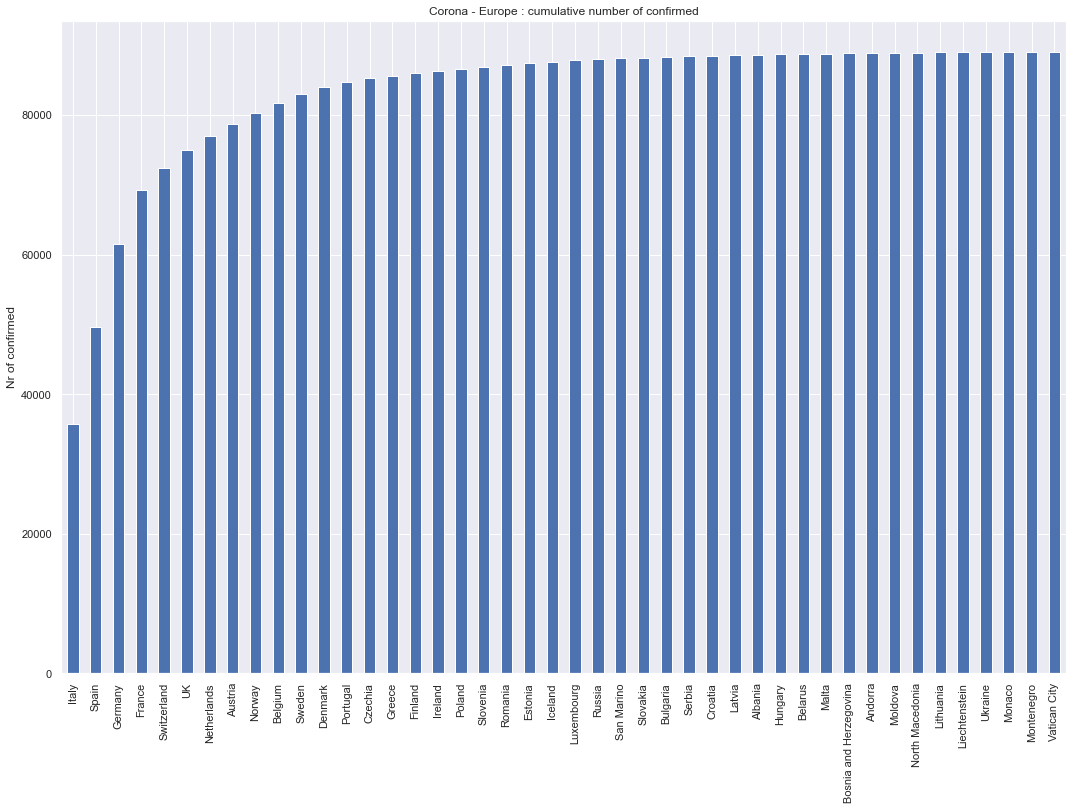

In [273]:
plt.figure(figsize=(18,12))
europe['confirmed'].cumsum().plot(kind='bar')
plt.title('Corona - Europe : cumulative number of confirmed')
plt.ylabel('Nr of confirmed')
plt.savefig('Corona_europe_cumulative.jpg',format='jpg')


In [274]:
def standardize(x):
    return (x - x.mean()) / x.std()

min_confirmed = 20
max_confirmed = 100000 # exclude e.g. China for better view

df_no_extrems = df.loc[ ( ( df['confirmed'] > min_confirmed  ) & ( df['confirmed'] < max_confirmed )) ]
df_no_extrems = df_no_extrems.loc[df_no_extrems['factor'] > 0]
df_no_extrems = df_no_extrems.loc[df_no_extrems['confirmed_per_M'] > 0]

x = df_no_extrems['confirmed_per_M']
x = standardize(x)
y = df_no_extrems['factor']
y = standardize(y)

In [275]:
# 

slope,intercept,_,_,_ = sps.linregress(x,y)

alpha_mu = 0
alpha_sigma = 0.5
beta_mu = 0
beta_sigma = 0.5


alpha = pm.Normal('alpha',mu=alpha_mu,tau = 1 / alpha_sigma ** 2)
beta = pm.Normal('beta',mu=beta_mu,tau = 1 / beta_sigma ** 2)

# by changing sigma from uniform to lognormal, the y-range of sample plot below
# shrunk a lot

sigma = pm.Uniform('sigma',lower=0,upper=10)

@pm.deterministic()
def linreq_mu(x=x,beta=beta,alpha=alpha):
    return x * beta + alpha

likelihood  = pm.Normal('likelihood',mu=linreq_mu,tau= 1 / sigma ** 2,
                       observed=True,value=y)

model = pm.Model([alpha,beta,sigma,linreq_mu,likelihood])
map_ = pm.MAP(model)
map_.fit()

mcmc = pm.MCMC(model)

mcmc.sample(10000,5000,2)

alpha_samples = mcmc.trace('alpha')[:]
beta_samples = mcmc.trace('beta')[:]
sigma_samples = mcmc.trace('sigma')[:]
linreq_mu_samples = mcmc.trace('sigma')[:]

result = pd.DataFrame({'alpha_post': alpha_samples,
                     'beta_post' : beta_samples,
                     'sigma_post' : sigma_samples,
                     'linreq_mu_post' : linreq_mu_samples})


 [-----------------100%-----------------] 10000 of 10000 complete in 12.3 sec

,alpha_post,beta_post,sigma_post,linreq_mu_post
count,2.500000e+03,2500.000000,2500.000000,2500.000000
mean,-5.196735e-06,-0.088604,1.007958,1.007958
std,2.016322e-05,0.111457,0.080596,0.080596
min,-1.151281e-04,-0.452776,0.791812,0.791812
25%,-2.191481e-08,-0.164635,0.952966,0.952966
50%,3.987002e-09,-0.090727,1.001062,1.001062
75%,4.876667e-07,-0.012255,1.060184,1.060184
max,3.976791e-05,0.296247,1.350884,1.350884


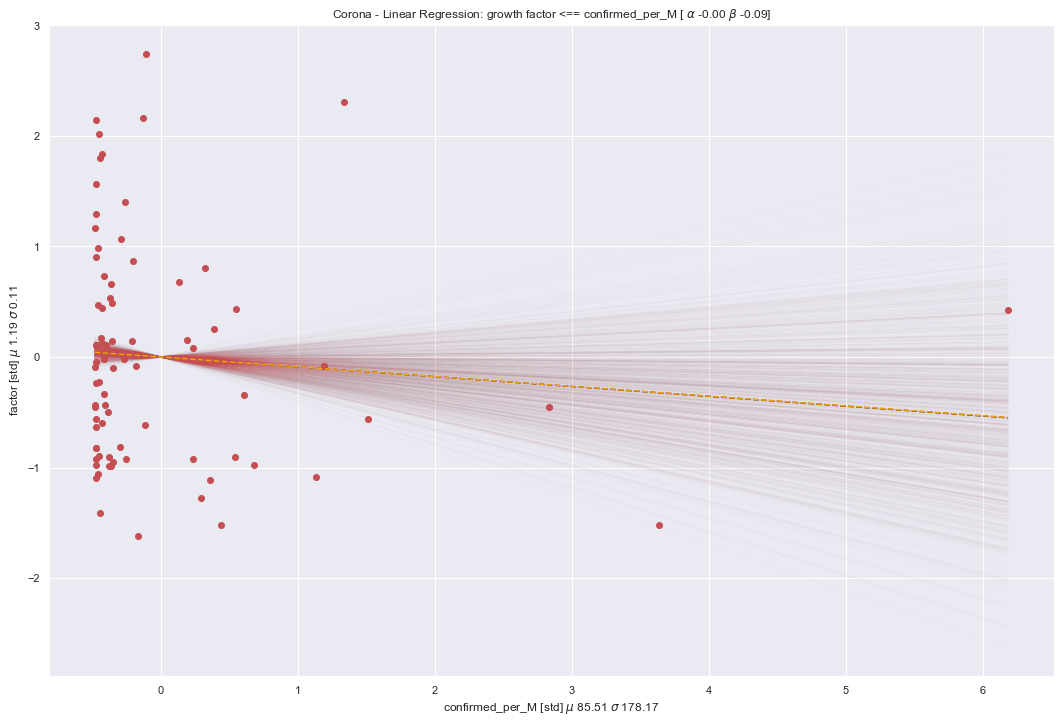

In [276]:

nr_rows = 100
nr_samples = 1000

alphas = np.random.choice(result['alpha_post'],replace=True,size=nr_samples)
betas = np.random.choice(result['beta_post'],replace=True,size=nr_samples)

X = np.linspace(x.min(),x.max(),nr_rows)

line_ys = np.array([X[i] * betas + alphas for i in range(len(X))])

plt.figure(figsize=(18,12))

line_alpha = result['alpha_post'].mean()
line_beta = result['beta_post'].mean()

plt.title(r'Corona - Linear Regression: growth factor <== confirmed_per_M [ $\alpha$ {:.2f} $\beta$ {:.2f}]'.format(
                                                                                        line_alpha,line_beta))

plt.ylabel(r'factor [std] $\mu$ {:.2f} $\sigma$ {:.2f}'.format(df_no_extrems['factor'].mean(),
                                                              df_no_extrems['factor'].std()))
plt.xlabel(r'confirmed_per_M [std] $\mu$ {:.2f} $\sigma$ {:.2f}'.format(df_no_extrems['confirmed_per_M'].mean(),
                                                             df_no_extrems['confirmed_per_M'].std()))
plt.scatter(x,y,color='r')
plt.plot(X,[X[i] * slope + intercept for i in range(len(X))],color='k',ls='dashed')
plt.plot(X,line_ys,color='r',alpha = 0.01)
plt.plot(X,[X[i] * result['beta_post'].mean() + result['alpha_post'].mean() for i in range(len(X))],
        color='orange',ls='dashed')
result.describe()


In [ ]:
plt.figure(figsize=(18,12))
plt.title ('Corona - Confirmed per Million in standardized units, as above')
plt.xlabel('confirmed per million [std]')
#df_no_extrems['confirmed_per_M'].sort_values().plot(kind='barh')
std_values = standardize(df_no_extrems['confirmed_per_M'])
_= std_values.sort_values().plot(kind='barh')

